In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from mplsoccer import Pitch
import matplotlib.patches as mpatches

# Ustawienie czcionki
plt.rcParams['font.family'] = 'DejaVu Sans'

# StatsBomb dimensions
PITCH_LENGTH = 120
PITCH_WIDTH = 80

# Pozycja początkowa (StatsBomb units)
start_x, start_y = 80, 25

# 5 komponentów - Twoje wartości (StatsBomb units)
components = [
    {
        'weight': 0.40,
        'pos': (50, 35),
        'sigma': (15, 5),
        'label': '1. Wycofanie do obrony',
        'color': 'blue'
    },
    {
        'weight': 0.30,
        'pos': (105, 25),
        'sigma': (10, 3),
        'label': '2. Dośrodkowanie',
        'color': 'red'
    },
    {
        'weight': 0.15,
        'pos': (95, 35),
        'sigma': (5, 3),
        'label': '3. Podanie na przedpole',
        'color': 'green'
    },
    {
        'weight': 0.05,
        'pos': (85, 65),
        'sigma': (15, 15),
        'label': '4. Przerzut na drugą stronę',
        'color': 'orange'
    },
    {
        'weight': 0.10,
        'pos': (65, 45),
        'sigma': (10, 8),
        'label': '5. Podanie do środka',
        'color': 'purple'
    },
]

# Tworzenie figury z mplsoccer
fig, ax = plt.subplots(figsize=(14, 9))
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='white')
pitch.draw(ax=ax)

# Grid dla heatmapy
x = np.linspace(0, PITCH_LENGTH, 300)
y = np.linspace(0, PITCH_WIDTH, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Oblicz heatmapę jako sumę ważonych Gaussów
for comp in components:
    weight = comp['weight']
    mu_x, mu_y = comp['pos']
    sigma_x, sigma_y = comp['sigma']
    
    # 2D Gaussian
    gauss = weight * np.exp(-((X - mu_x)**2 / (2 * sigma_x**2) + 
                               (Y - mu_y)**2 / (2 * sigma_y**2)))
    Z += gauss

# Plot heatmap
im = ax.imshow(Z, extent=[0, PITCH_LENGTH, 0, PITCH_WIDTH], 
               origin='lower', cmap='YlOrRd', alpha=0.5, aspect='auto', zorder=0.5)
cbar = plt.colorbar(im, ax=ax, label='Gęstość prawdopodobieństwa', 
                    fraction=0.046, pad=0.04)

# Dodaj markery dla każdego komponentu
for i, comp in enumerate(components, 1):
    mu_x, mu_y = comp['pos']
    sigma_x, sigma_y = comp['sigma']
    color = comp['color']
    weight = comp['weight']
    
    # Elipsa pokazująca 1-sigma region
    ellipse = Ellipse(xy=(mu_x, mu_y), width=2*sigma_x, height=2*sigma_y,
                      edgecolor=color, facecolor='none', linewidth=2.5, 
                      linestyle='--', alpha=0.9, zorder=2)
    ax.add_patch(ellipse)
    
    # Marker w centrum (średnia)
    ax.scatter(mu_x, mu_y, s=200, color=color, edgecolor='black', 
               linewidth=1.5, zorder=3, marker='o')
    
    # Etykieta z wagą obok punktu
    ax.text(mu_x + 2, mu_y + 2, f'π={weight:.2f}', 
            fontsize=9, color=color, fontweight='bold', zorder=4,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor=color))

# Pozycja początkowa (START)
ax.scatter(start_x, start_y, s=400, color='yellow', marker='s',
           edgecolor='black', linewidth=2.5, zorder=5)
ax.text(start_x, start_y - 4, 'START\n(80, 25)', 
        ha='center', fontsize=10, fontweight='bold', zorder=5,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.95, edgecolor='black'))

ax.set_title('Mixture Density Network: rozkład prawdopodobieństwa końcowej pozycji podania\n' + 
             'Sytuacja startowa: skrzydło w ofensywnej strefie (x=80, y=25, jednostki StatsBomb)', 
             fontsize=13, fontweight='bold', pad=15, color='white')

# Legenda - komponenty
legend_elements = []
for comp in components:
    legend_elements.append(mpatches.Patch(facecolor=comp['color'], 
                                         edgecolor='black', 
                                         label=comp['label'] + f" (π={comp['weight']:.2f})"))

ax.legend(handles=legend_elements, loc='upper left', fontsize=9.5, 
          framealpha=0.95, edgecolor='white', title='Komponenty mieszaniny',
          title_fontsize=10, facecolor='#22312b', labelcolor='white')

plt.tight_layout()
plt.savefig('mdn_heatmap_statsbomb.png', dpi=300, bbox_inches='tight', facecolor='#22312b')
plt.show()

print("✅ Wykres zapisany jako 'mdn_heatmap_statsbomb.png'")
print(f"\nPozycja startowa: ({start_x}, {start_y}) [jednostki StatsBomb]")
print("\nKomponenty:")
for i, comp in enumerate(components, 1):
    x, y = comp['pos']
    sx, sy = comp['sigma']
    print(f"{i}. {comp['label']}: μ=({x}, {y}), σ=({sx}, {sy}), π={comp['weight']}")

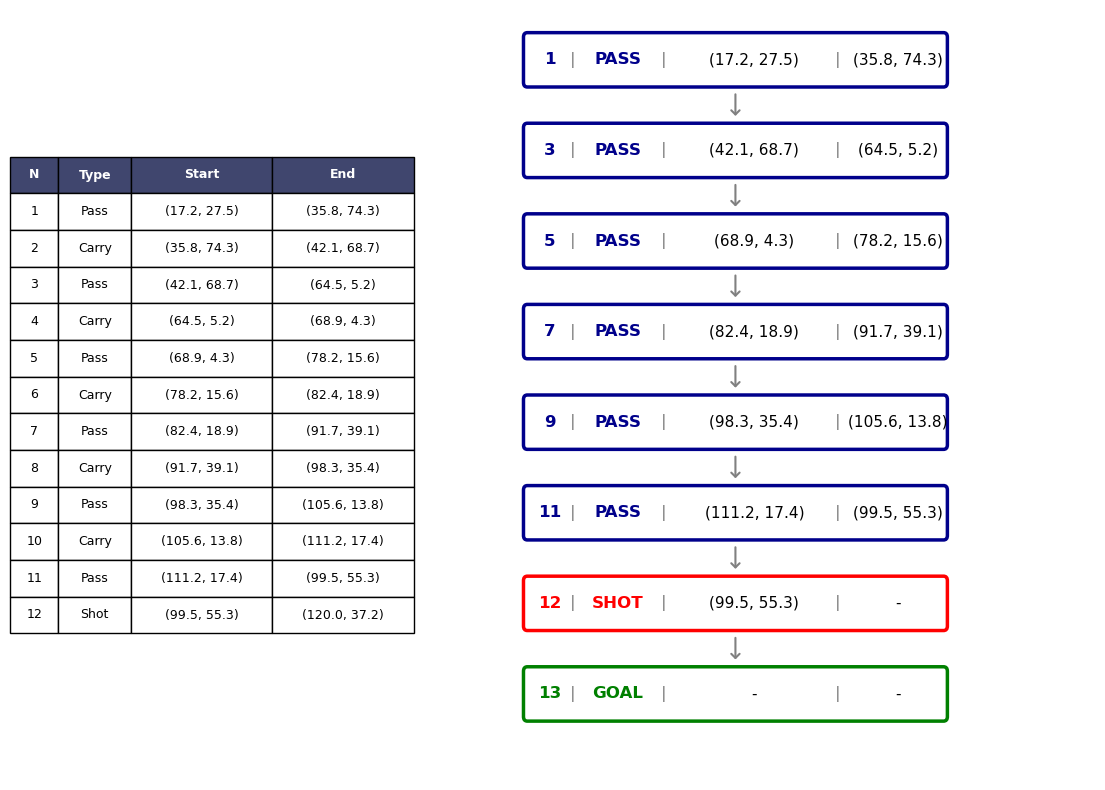

In [42]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

# Definicja sekwencji akcji
passes = [
    (17.2, 27.5, 35.8, 74.3),
    (42.1, 68.7, 64.5, 5.2),
    (68.9, 4.3, 78.2, 15.6),
    (82.4, 18.9, 91.7, 39.1),
    (98.3, 35.4, 105.6, 13.8),
    (111.2, 17.4, 99.5, 55.3)
]

carries = [
    (35.8, 74.3, 42.1, 68.7),
    (64.5, 5.2, 68.9, 4.3),
    (78.2, 15.6, 82.4, 18.9),
    (91.7, 39.1, 98.3, 35.4),
    (105.6, 13.8, 111.2, 17.4)
]

shot = (99.5, 55.3, 120.0, 37.2)

# Przygotowanie danych do tabeli (z Carry)
table_data = []
event_num = 1

for i, pass_coords in enumerate(passes):
    table_data.append({
        'N': event_num,
        'Type': 'Pass',
        'Start': f"({pass_coords[0]:.1f}, {pass_coords[1]:.1f})",
        'End': f"({pass_coords[2]:.1f}, {pass_coords[3]:.1f})"
    })
    event_num += 1
    
    # Sprawdź czy po tym passie jest carry
    for carry_coords in carries:
        if abs(carry_coords[0] - pass_coords[2]) < 0.1 and abs(carry_coords[1] - pass_coords[3]) < 0.1:
            table_data.append({
                'N': event_num,
                'Type': 'Carry',
                'Start': f"({carry_coords[0]:.1f}, {carry_coords[1]:.1f})",
                'End': f"({carry_coords[2]:.1f}, {carry_coords[3]:.1f})"
            })
            event_num += 1
            break

# Dodaj strzał
table_data.append({
    'N': event_num,
    'Type': 'Shot',
    'Start': f"({shot[0]:.1f}, {shot[1]:.1f})",
    'End': f"({shot[2]:.1f}, {shot[3]:.1f})"
})

df = pd.DataFrame(table_data)

# Przygotowanie tokenów (bez Carry)
tokens = []
token_num = 1

for pass_coords in passes:
    tokens.append({
        'num': token_num,
        'type': 'PASS',
        'start': f"({pass_coords[0]:.1f}, {pass_coords[1]:.1f})",
        'end': f"({pass_coords[2]:.1f}, {pass_coords[3]:.1f})",
        'color': 'darkblue'
    })
    token_num += 2  # Pomijamy Carry

tokens.append({
    'num': len(table_data),
    'type': 'SHOT',
    'start': f"({shot[0]:.1f}, {shot[1]:.1f})",
    'end': '-',
    'color': 'red'
})

tokens.append({
    'num': len(table_data) + 1,
    'type': 'GOAL',
    'start': '-',
    'end': '-',
    'color': 'green'
})

# Utworzenie figury z dwoma subplotami
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[0.8, 1.2], wspace=0.15)

# ===== Subplot 1: Tabela =====
ax_table = fig.add_subplot(gs[0])
ax_table.axis('tight')
ax_table.axis('off')

table = ax_table.table(cellText=df.values, colLabels=df.columns,
                       cellLoc='center', loc='center',
                       colWidths=[0.12, 0.18, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.2)

# Stylizacja nagłówków
for i in range(len(df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# ===== Subplot 2: Tokeny =====
ax_tokens = fig.add_subplot(gs[1])
ax_tokens.axis('off')

# Parametry tokenów - szersze boksy
box_width = 5.5
box_height = 0.5
x_start = 0.5
y_start = 0
spacing = 1

# Ustaw limity
ax_tokens.set_xlim(0, 8)
ax_tokens.set_ylim(-len(tokens) * spacing - 0.2, 0.3)

# Rysowanie tokenów
for i, token in enumerate(tokens):
    y_pos = y_start - i * spacing
    
    # Rysowanie boksu
    box = FancyBboxPatch(
        (x_start, y_pos - box_height), 
        box_width, 
        box_height,
        boxstyle="round,pad=0.05",
        edgecolor=token['color'],
        facecolor='white',
        linewidth=2.5
    )
    ax_tokens.add_patch(box)
    
    text_y = y_pos - box_height/2
    
    # Numer
    ax_tokens.text(x_start + 0.3, text_y,
            f"{token['num']}", 
            fontsize=12, fontweight='bold', ha='center', va='center',
            color=token['color'])
    
    # Separator
    ax_tokens.text(x_start + 0.6, text_y, "|", 
            fontsize=12, ha='center', va='center', color='gray')
    
    # Typ
    ax_tokens.text(x_start + 1.2, text_y,
            token['type'], 
            fontsize=12, fontweight='bold', ha='center', va='center',
            color=token['color'])
    
    # Separator
    ax_tokens.text(x_start + 1.8, text_y, "|", 
            fontsize=12, ha='center', va='center', color='gray')
    
    # Start Location
    start_text = token['start'] if token['start'] != '-' else '-'
    ax_tokens.text(x_start + 3.0, text_y,
            start_text, 
            fontsize=11, ha='center', va='center', color='black')
    
    # Separator
    ax_tokens.text(x_start + 4.1, text_y, "|", 
            fontsize=12, ha='center', va='center', color='gray')
    
    # End Location
    end_text = token['end'] if token['end'] != '-' else '-'
    ax_tokens.text(x_start + 4.9, text_y,
            end_text, 
            fontsize=11, ha='center', va='center', color='black')
    
    # Strzałka do następnego tokenu
    if i < len(tokens) - 1:
        arrow = FancyArrowPatch(
            (x_start + box_width/2, y_pos - box_height - 0.1),
            (x_start + box_width/2, y_pos - box_height - 0.4),
            arrowstyle='->,head_width=3,head_length=3',
            color='gray',
            linewidth=1.5
        )
        ax_tokens.add_patch(arrow)

plt.tight_layout()
plt.savefig('veezes/tabela_tokeny.png', dpi=300, bbox_inches='tight')
plt.show()

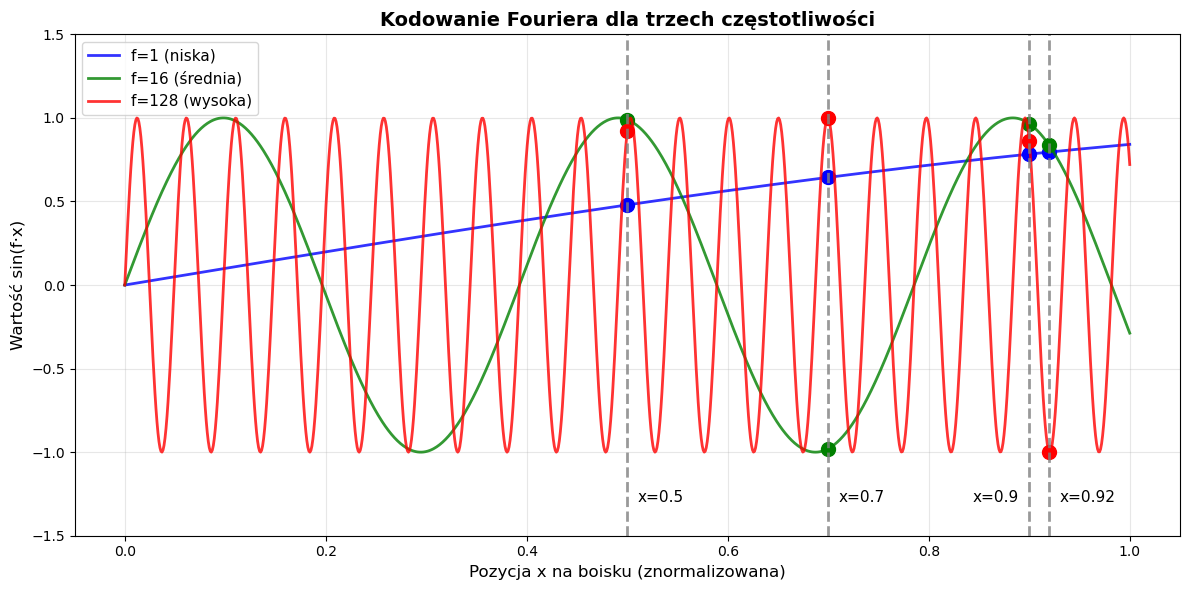

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Ustawienie czcionki
plt.rcParams['font.family'] = 'DejaVu Sans'

x = np.linspace(0, 1, 1000)
positions = [0.5, 0.7, 0.9, 0.92]
freqs = [1, 16, 128]
colors = ['blue', 'green', 'red']
labels = ['f=1 (niska)', 'f=16 (średnia)', 'f=128 (wysoka)']

fig, ax = plt.subplots(figsize=(12, 6))

# Trzy sinusoidy
for f, color, label in zip(freqs, colors, labels):
    ax.plot(x, np.sin(f * x), color=color, linewidth=2, label=label, alpha=0.8)
    
    # Punkty na 4 pozycjach
    for pos in positions:
        ax.plot(pos, np.sin(f * pos), 'o', color=color, markersize=10)

# Pionowe linie przy pozycjach
for i, pos in enumerate(positions):
    ax.axvline(pos, color='gray', linestyle='--', alpha=0.8, linewidth=2)
    
    # Etykiety - rozsuń x=0.9 i x=0.92
    if pos == 0.9:
        ax.text(pos - 0.01, -1.3, f'x={pos}', ha='right', fontsize=11)
    elif pos == 0.92:
        ax.text(pos + 0.01, -1.3, f'x={pos}', ha='left', fontsize=11)
    else:
        ax.text(pos + 0.01, -1.3, f'x={pos}', ha='left', fontsize=11)

ax.set_xlabel('Pozycja x na boisku (znormalizowana)', fontsize=12)
ax.set_ylabel('Wartość sin(f·x)', fontsize=12)
ax.set_title('Kodowanie Fouriera dla trzech częstotliwości', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.savefig('veezes/fourier_encoding_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

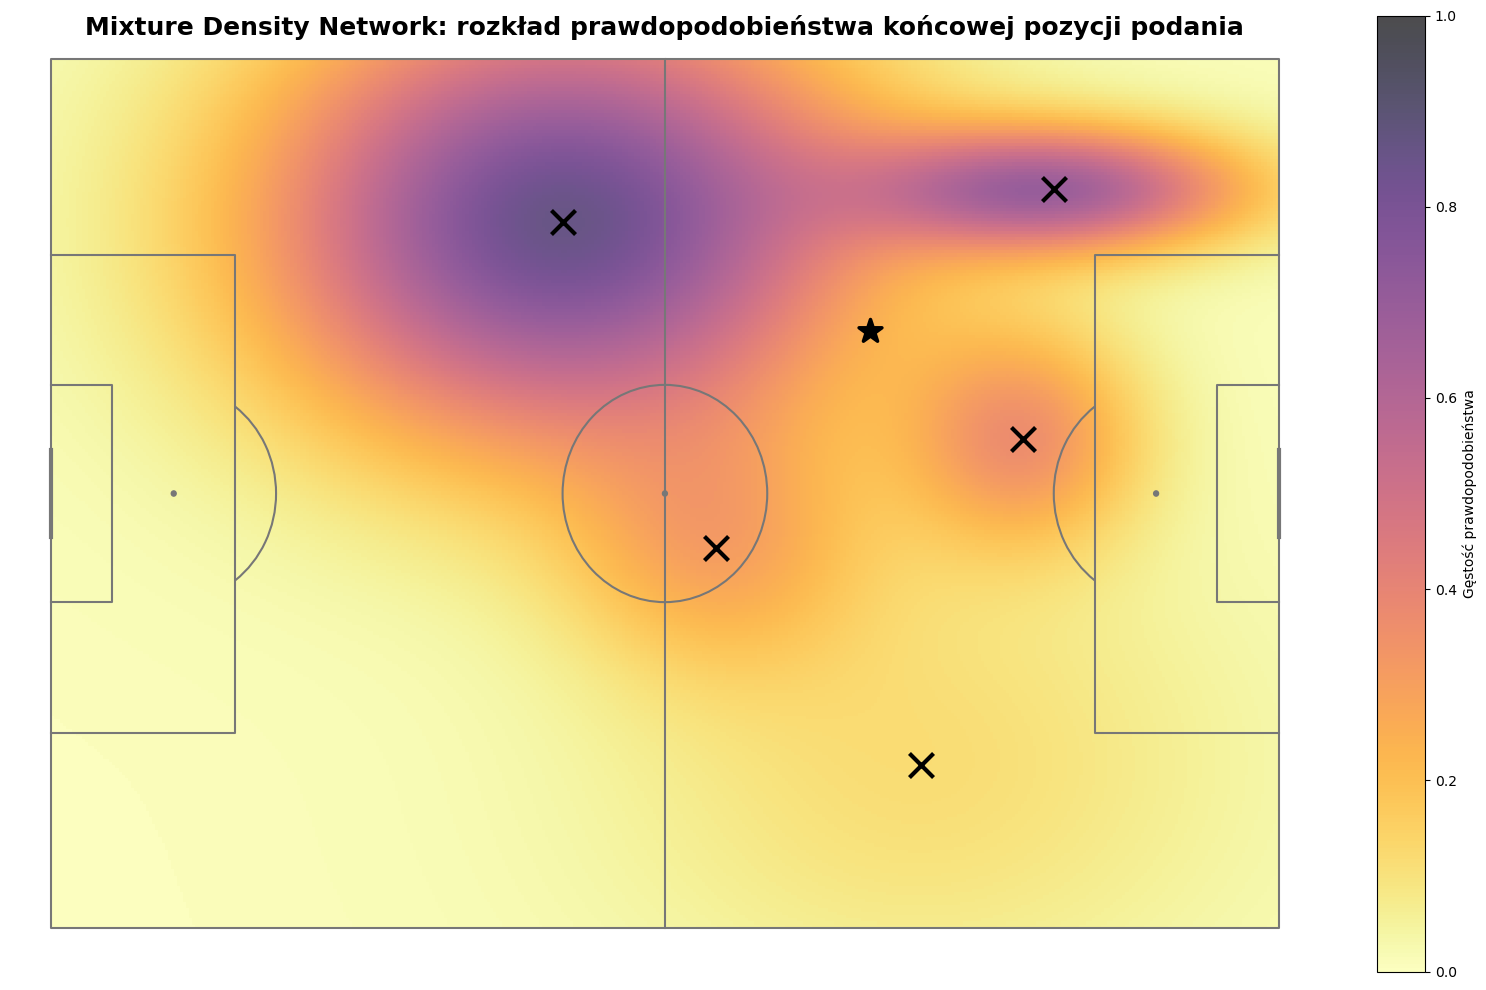

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from mplsoccer import Pitch
import matplotlib.patches as mpatches

# Ustawienie czcionki
plt.rcParams['font.family'] = 'DejaVu Sans'

# StatsBomb dimensions
PITCH_LENGTH = 120
PITCH_WIDTH = 80

# Pozycja początkowa (StatsBomb units)
start_x, start_y = 80, 25

# 5 komponentów - Twoje wartości (StatsBomb units)
components = [
    {
        'weight': 0.40,
        'pos': (50, 15),
        'sigma': (20, 14)
    },
    {
        'weight': 0.30,
        'pos': (98, 12),
        'sigma': (13, 4)
    },
    {
        'weight': 0.15,
        'pos': (95, 35),
        'sigma': (8, 7)
    },
    {
        'weight': 0.05,
        'pos': (85, 65),
        'sigma': (21, 15)
    },
    {
        'weight': 0.10,
        'pos': (65, 45),
        'sigma': (10, 8)
    },
]

# Tworzenie figury z mplsoccer
fig, ax = plt.subplots(figsize=(15, 10))
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='#777777', linewidth=1.5)
pitch.draw(ax=ax)

# Grid dla heatmap
x = np.linspace(0, PITCH_LENGTH, 400)
y = np.linspace(0, PITCH_WIDTH, 267)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Oblicz łączną heatmapę jako sumę ważonych Gaussów
for comp in components:
    weight = comp['weight']
    mu_x, mu_y = comp['pos']
    sigma_x, sigma_y = comp['sigma']
    
    # 2D Gaussian
    gauss = weight * np.exp(-((X - mu_x)**2 / (2 * sigma_x**2) + 
                               (Y - mu_y)**2 / (2 * sigma_y**2)))
    Z += gauss

# Skalowanie aby nawet najsłabszy komponent był widoczny
# Normalizujemy do [0, 1], ale ustawiamy minimum na 0.1 żeby wszystko było widoczne
Z_min = Z[Z > 1e-4].min() if (Z > 1e-4).any() else 0
Z_max = Z.max()

# Przeskaluj tak żeby min=0.15, max=1.0 (żeby żółty był widoczny)
Z_scaled = np.where(Z > 1e-4, 
                    0.01 + (Z - Z_min) / (Z_max - Z_min) * 0.85, 
                    0)

# Plot heatmap z skalą żółty → pomarańczowy → czerwony
im = ax.imshow(Z_scaled, extent=[0, PITCH_LENGTH, 0, PITCH_WIDTH], 
               origin='lower', cmap='inferno_r', alpha=0.7, aspect='auto', 
               zorder=0.5, vmin=0, vmax=1)


# Colorbar
cbar = plt.colorbar(im, ax=ax, label='Gęstość prawdopodobieństwa', 
                    fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

# Dodaj markery dla każdego komponentu
for i, comp in enumerate(components, 1):
    mu_x, mu_y = comp['pos']
    sigma_x, sigma_y = comp['sigma']
    
    # Czarny krzyżyk w centrum (średnia)
    ax.scatter(mu_x, mu_y, s=300, color='black', marker='x', 
               linewidth=3, zorder=3)

# Pozycja początkowa (START)
ax.scatter(start_x, start_y, s=300, color='black', marker='*',
           edgecolor='black', linewidth=2.5, zorder=5)

plt.tight_layout()

ax.set_title('Mixture Density Network: rozkład prawdopodobieństwa końcowej pozycji podania', 
             fontsize=18, fontweight='bold', pad=0, y=0.98)

plt.savefig('mdn_heatmap_statsbomb.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()